In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import CLIPProcessor, CLIPModel

In [ ]:
! unzip '/content/drive/Othercomputers/My laptop/D:/escape internship/Environment Detection/Dataset_Main.zip'

Archive:  /content/drive/Othercomputers/My laptop/D:/escape internship/Environment Detection/Dataset_Main.zip
replace Dataset_Main/COMMERCIAL PLACES/gsun_000263f3fb61a5f8533dbbf9e219c7f6.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Set dataset path
dataset_path = '/content/Dataset_Main'  # Change this to your dataset location

In [ ]:
# Data Visualization
def plot_sample_images(dataset_path, num_images=5):
    categories = os.listdir(dataset_path)
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories[:num_images]):
        img_path = os.path.join(dataset_path, category, os.listdir(os.path.join(dataset_path, category))[0])
        img = plt.imread(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

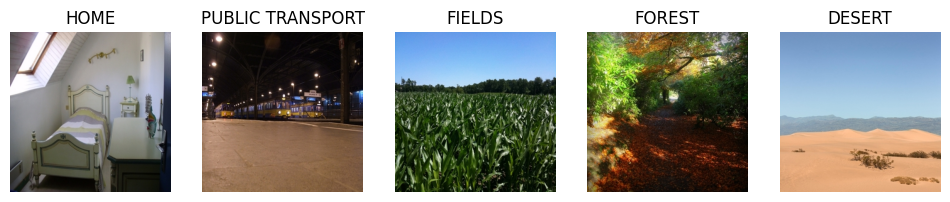

In [ ]:
plot_sample_images(dataset_path)

In [ ]:
# Data Preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(
    dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')

Found 61152 images belonging to 12 classes.
Found 15282 images belonging to 12 classes.


In [ ]:
# Load CLIP Model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", do_rescale=False)

def clip_encode_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)
    inputs = clip_processor(images=image, return_tensors="pt")
    features = clip_model.get_image_features(**inputs)
    return features.detach().numpy()

In [ ]:
# Data Preparation
image_paths = []
labels = []
categories = os.listdir(dataset_path)
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_name))
        labels.append(category)

In [ ]:
# Extract CLIP features
features = np.array([clip_encode_image(img_path) for img_path in image_paths])
labels = np.array(labels)

KeyboardInterrupt: 

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Model Definition with Early Stopping
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm = SVC(probability=True)

grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

In [ ]:
# Best Model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test.reshape(X_test.shape[0], -1))
print(classification_report(y_test, y_pred))

In [ ]:
# Early Stopping Check
train_acc = accuracy_score(y_train, best_model.predict(X_train.reshape(X_train.shape[0], -1)))
test_acc = accuracy_score(y_test, y_pred)

early_stopping_threshold = 0.05  # Threshold for overfitting detection
if train_acc - test_acc > early_stopping_threshold:
    print("Warning: Model may be overfitting! Consider revising the model or gathering more data.")

# Save Model
import joblib
joblib.dump(best_model, "clip_classifier.pkl")